## NHC Track-Forecasting CLIPER
The following Data is contained in the preprocessed best track dataset.

0    Calendar day
1    Latitude +24
2    Longitude +24
3    Max sustained wind in knts +24
4    Latitude +18
5    Longitude +18
6    Max sustained wind in knts +18
7    Latitude +12
8    Longitude +12
9   Max sustained wind in knts +12
10   Latitude +6
11   Longitude +6
12   Max sustained wind in knts +6
13   Latitude 0
14   Longitude 0
15   Max sustained wind in knts 0
16   Latitude -6
17   Longitude -6
18   Max sustained wind in knts -6
19   Latitude -12
20   Longitude -12
21   Max sustained wind in knts -12
22   Latitude -18
23   Longitude -18
24   Max sustained wind in knts

In [13]:
# Import Data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

data = np.genfromtxt('Hudrat2Preprocessed.csv', delimiter=',')

In [14]:
data_Meridional = np.empty((data.shape[0], 14))
data_Zonal = np.empty((data.shape[0], 9))
target = np.empty((data.shape[0], 8))
for i in range(0, data.shape[0]):
# Meridional data
    V0 = data[i, 13]-data[i, 16]
    V_12 = data[i, 19]-data[i, 22]
    V0V_12q = V0*V_12**2
    W_71 = data[i,15]-71
    W_71V_12 = W_71*V_12
    W_71V0 = W_71*V0
    U_12 = data[i,20]-data[i,23]
    V0qU_12 = V0**2*U_12
    Y_24qV0 = (data[i,13]-24)**2*V0
    D = data[i,0]
    D_248qV_12 = (D-248)**2*V_12
    V0D_248q = V0*(D-248)**2
    Y_24qD_248 = (data[i,13]-24)**2*(D-248)
    W_71D_248_V_12 = W_71*(D-248)*V_12
    U0 = data[i,15]-data[i,18]
    D_248q = (D-248)**2
    data_Meridional[i,:] = data[i,13], V0, V_12, V0V_12q, W_71V_12, W_71V0, V0qU_12, Y_24qV0, D_248qV_12, V0D_248q, Y_24qD_248, W_71D_248_V_12, U0, D_248q
# Zonal Data
    U0 = data[i,14]-data[i,17]
    U_12 = data[i,20]-data[i,23]
    Y_24 = data[i,13]-24
    V0 = data[i,13]-data[i,16]
    V0qU_12 = V0**2*U_12
    Y0_24V0U_12 = (data[i,13]-24)*V0*U_12
    X0_68 = data[i,14]-68
    #additional ========
    W_12 = data[i,21]-data[i,24]
    #===================
    data_Zonal[i,:] = data[i,14], U0, U_12, Y_24, V0, V0qU_12, Y0_24V0U_12, X0_68, W_12
# Target
    V_6 = data[i,10]-data[i,13]
    U_6 = data[i,11]-data[i,14]
    V_12 = data[i,7]-data[i,13]
    U_12 = data[i,8]-data[i,14]
    V_18 = data[i,4]-data[i,13]
    U_18 = data[i,5]-data[i,14]
    V_24 = data[i,1]-data[i,13]
    U_24 = data[i,2]-data[i,14]
    target[i, :]= V_6,V_12,V_18,V_24,U_6,U_12,U_18,U_24

Dividing the data into a train and test dataset for validation of prediction acuracy.

In [15]:
r = 32000
train_Zonal = data_Zonal[0:r-1,:]
train_Meridional = data_Meridional[0:r-1,:]
train_target = target[0:r-1,:]

test_Zonal = data_Zonal[r:,:]
test_Meridional = data_Meridional[r:,:]
test_target = target[r:,:]


## Linear Regression
$$dX = c_0 + \sum_{i=1}^8 c_i P_i$$

$$dY= c_0 + \sum_{i=1}^{14} c_i P_i$$

In [16]:
def train_model(train_merid, train_zon):
    cmerid = np.empty((train_Meridional.shape[1],4))
    czonal = np.empty((train_Zonal.shape[1],4))
    for i in range(0,4):
        cmerid[:,i] = np.linalg.pinv(train_Meridional) @ train_target[:,i]
    for i in range(0,4):
        czonal[:,i] = np.linalg.pinv(train_Zonal) @ train_target[:,i+4]
    return cmerid ,czonal

cm, cz = train_model(train_Meridional, train_Zonal)

Prediction of test dataset. (For better visualisation in sorted order.)

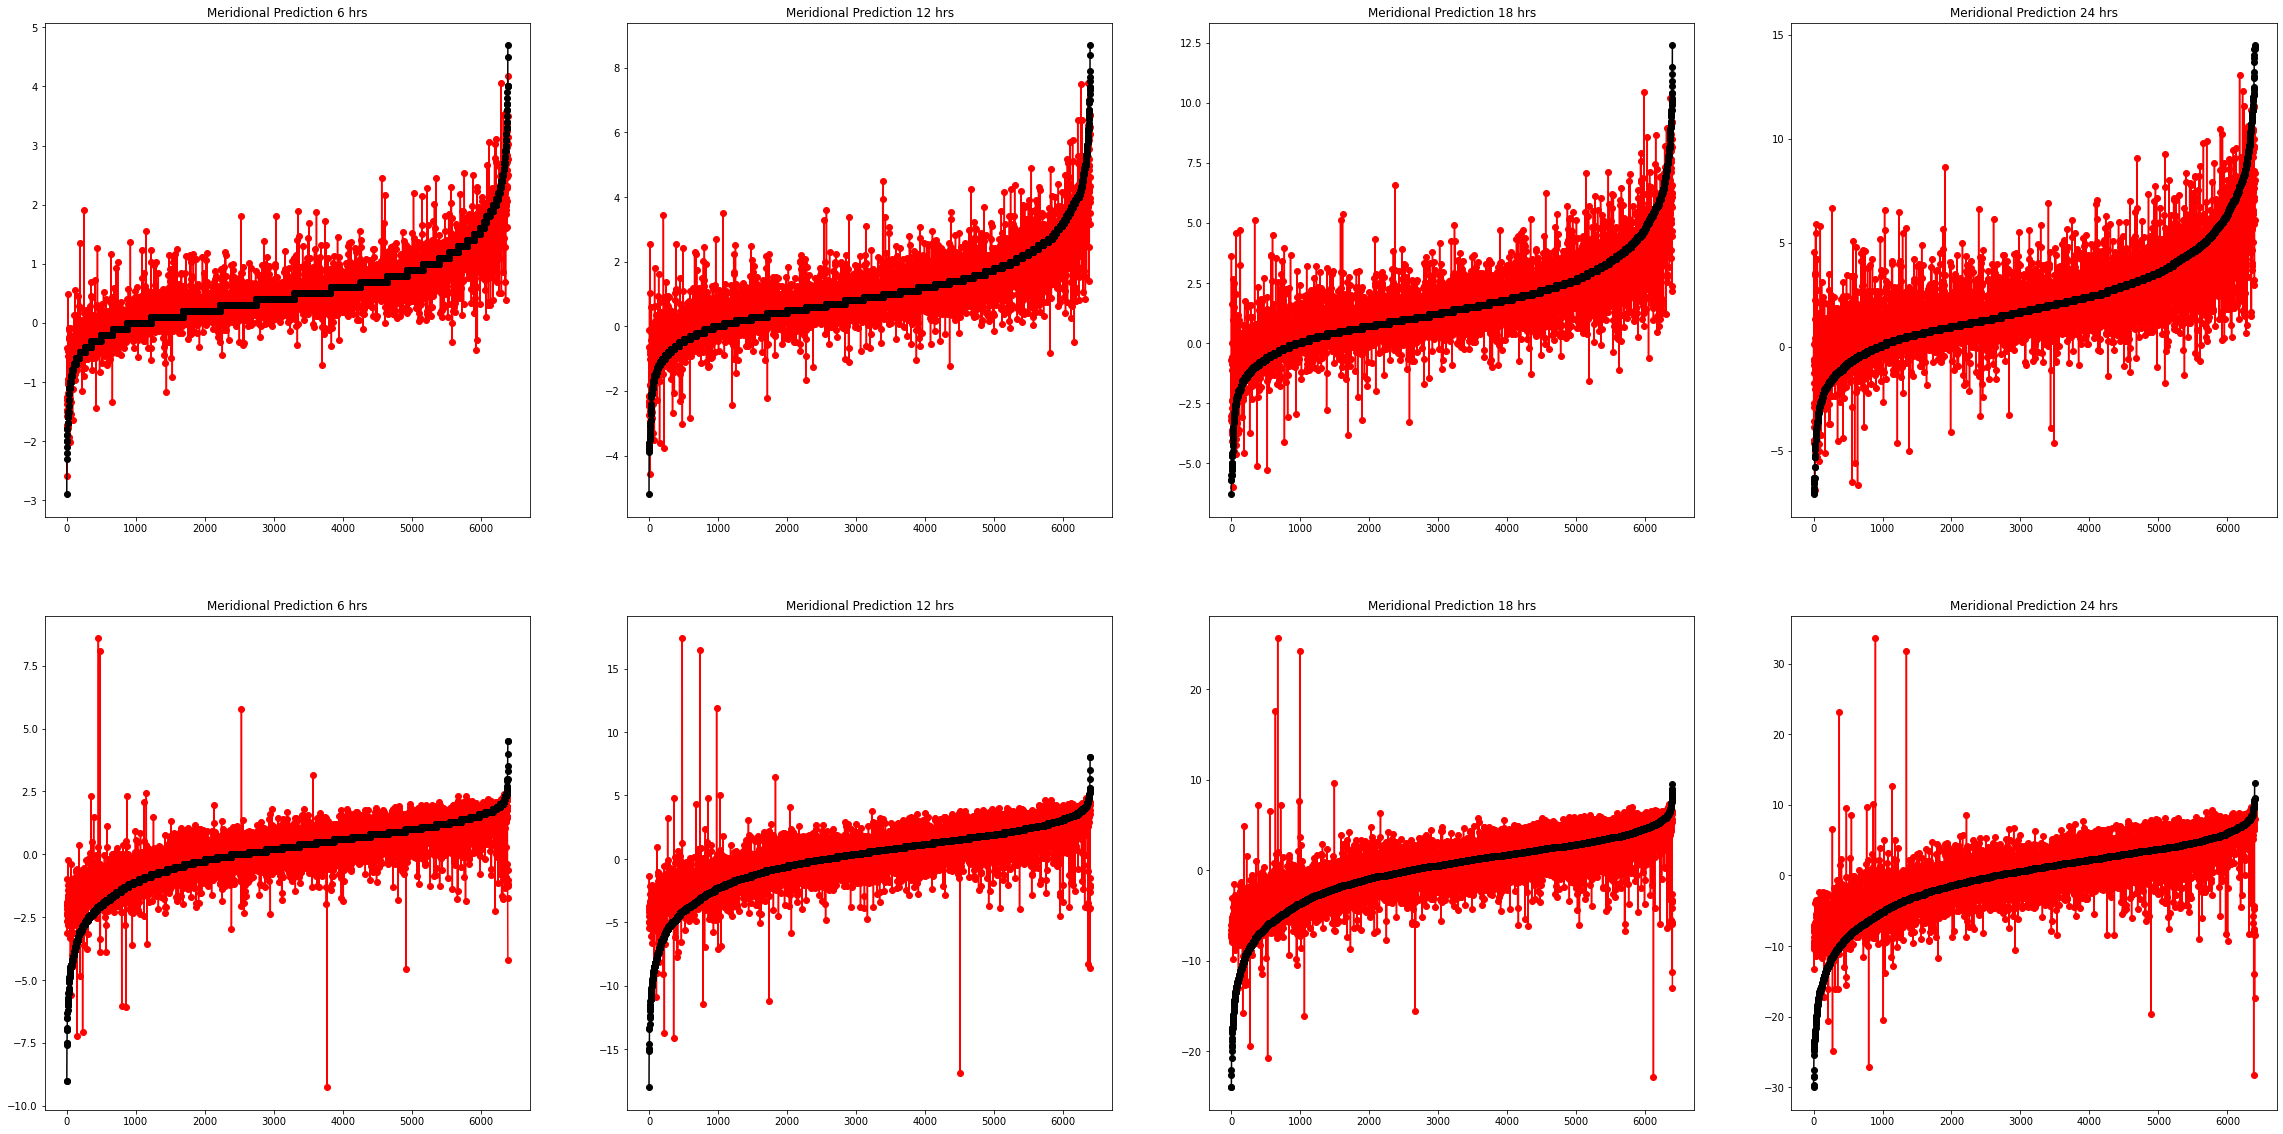

In [17]:
ind = np.empty((test_target.shape[0],8))
for i in range(0,8):
    ind[:,i] = np.argsort(test_target[:,i])

plt.figure(figsize=(40,20))
for i in range(1, 5):
    plt.subplot(2,4,i)
    plt.plot(test_Meridional[np.int_(ind[:,i-1]),:] @ cm[:,i-1], 'r-', marker='o')
    plt.plot(test_target[np.int_(ind[:,i-1]),i-1], 'k-', marker='o')
    plt.title('Meridional Prediction '+str(i*6)+' hrs')
for i in range(5, 9):
    plt.subplot(2,4,i)
    plt.plot(test_Zonal[np.int_(ind[:,i-1]),:] @ cz[:,i-5], 'r-', marker='o')
    plt.plot(test_target[np.int_(ind[:,i-1]),i-1], 'k-', marker='o')
    plt.title('Meridional Prediction '+str((i-4)*6)+' hrs')
plt.show()

Forecasting Error of linear Regression

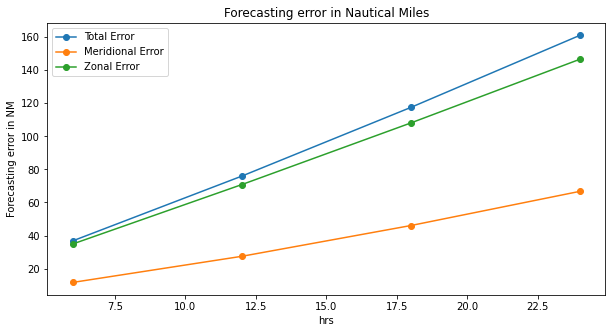

In [18]:
err_Meridional = np.sum(np.abs(test_target[:,:4]-test_Meridional@cm),0)/test_target.shape[0]
err_Zonal = np.sum(np.abs(test_target[:,4:]-test_Zonal@cz),0)/test_target.shape[0]
err = np.sqrt(err_Meridional**2+err_Zonal**2)
t = [6, 12, 18, 24]
plt.figure(figsize=(10,5))
plt.plot(t,err*60, marker='o')
plt.plot(t,err_Meridional*60, marker='o')
plt.plot(t,err_Zonal*60, marker='o')
plt.legend(['Total Error', 'Meridional Error', 'Zonal Error'])
plt.title('Forecasting error in Nautical Miles')
plt.xlabel('hrs')
plt.ylabel('Forecasting error in NM')
plt.show()


Visualisation of Forecast with linear regression

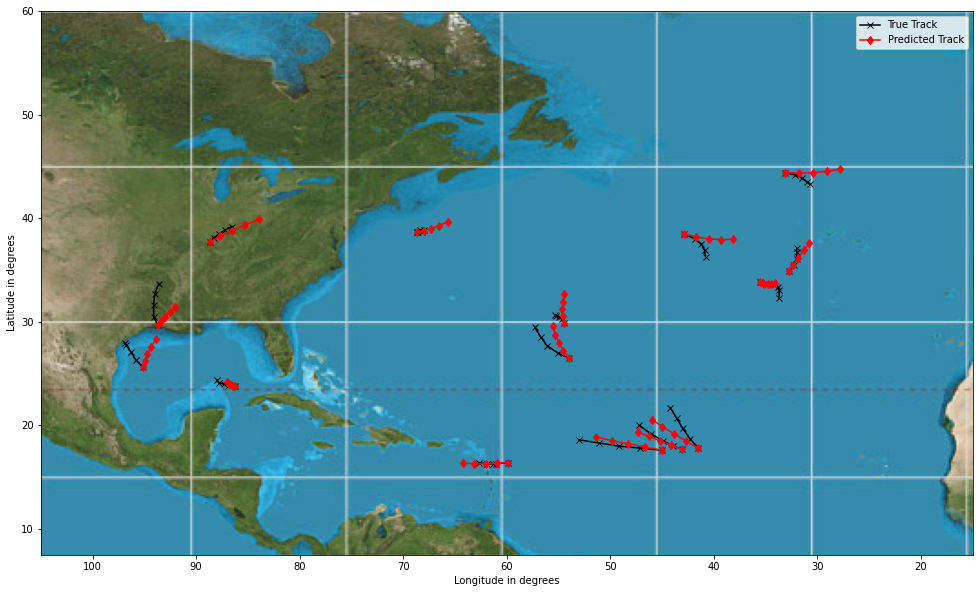

In [19]:
def visualise():
    plt.figure(figsize=(20,10))
    plt.imshow(imread('Map.jpg'),extent=[7*180/12, -180/12+0.5, -90/6,4*90/6,])

    n = np.random.randint(test_target.shape[0],size=15)
    track_m,track_z,pred_m,pred_z = np.empty(5),np.empty(5),np.empty(5),np.empty(5)
    for i in n:
        track_m[0] = test_Meridional[i,0]
        track_m[1:] = test_target[i,:4]+test_Meridional[i,0]
        track_z[0] = test_Zonal[i,0]
        track_z[1:] = test_target[i,4:]+test_Zonal[i,0]
        pred_m[0] = test_Meridional[i,0]
        pred_m[1:] = test_Meridional[i,:].dot(cm) + test_Meridional[i,0]
        pred_z[0] = test_Zonal[i,0]
        pred_z[1:] = test_Zonal[i,:].dot(cz) + test_Zonal[i,0]

        plt.plot(track_z,track_m,'k', marker='x')
        plt.plot(pred_z,pred_m,'r', marker='d')
    plt.legend(['True Track','Predicted Track'])
    plt.axis([7*180/12, 180/12, 90/12, 4*90/6])
    plt.xlabel('Longitude in degrees')
    plt.ylabel('Latitude in degrees')
    plt.show()
visualise()

## Polynomial Regression
$$ dX = c_0 + \sum_{i=1}^8  \sum_{j=1}^3 c_{i,j} P_i^j $$

$$ dY= c_0 + \sum_{i=1}^{14} \sum_{j=1}^3 c_{i,j} P_i^j $$

In [20]:
# Extend data matrix
data_Meridional1 = np.concatenate((data_Meridional,np.ma.power(data_Meridional,2)),axis=1)
data_Meridional = np.concatenate((data_Meridional1,np.ma.power(data_Meridional,3)),axis=1)
data_Zonal1 = np.concatenate((data_Zonal,np.ma.power(data_Zonal,2)),axis=1)
data_Zonal = np.concatenate((data_Zonal1,np.ma.power(data_Zonal,3)),axis=1)

r = 32000
train_Zonal = data_Zonal[0:r-1,:]
train_Meridional = data_Meridional[0:r-1,:]
test_Zonal = data_Zonal[r:,:]
test_Meridional = data_Meridional[r:,:]


In [21]:
# Train model
cm, cz = train_model(train_Meridional,train_Zonal)


Prediction of test dataset. (For better visualisation in sorted order.)

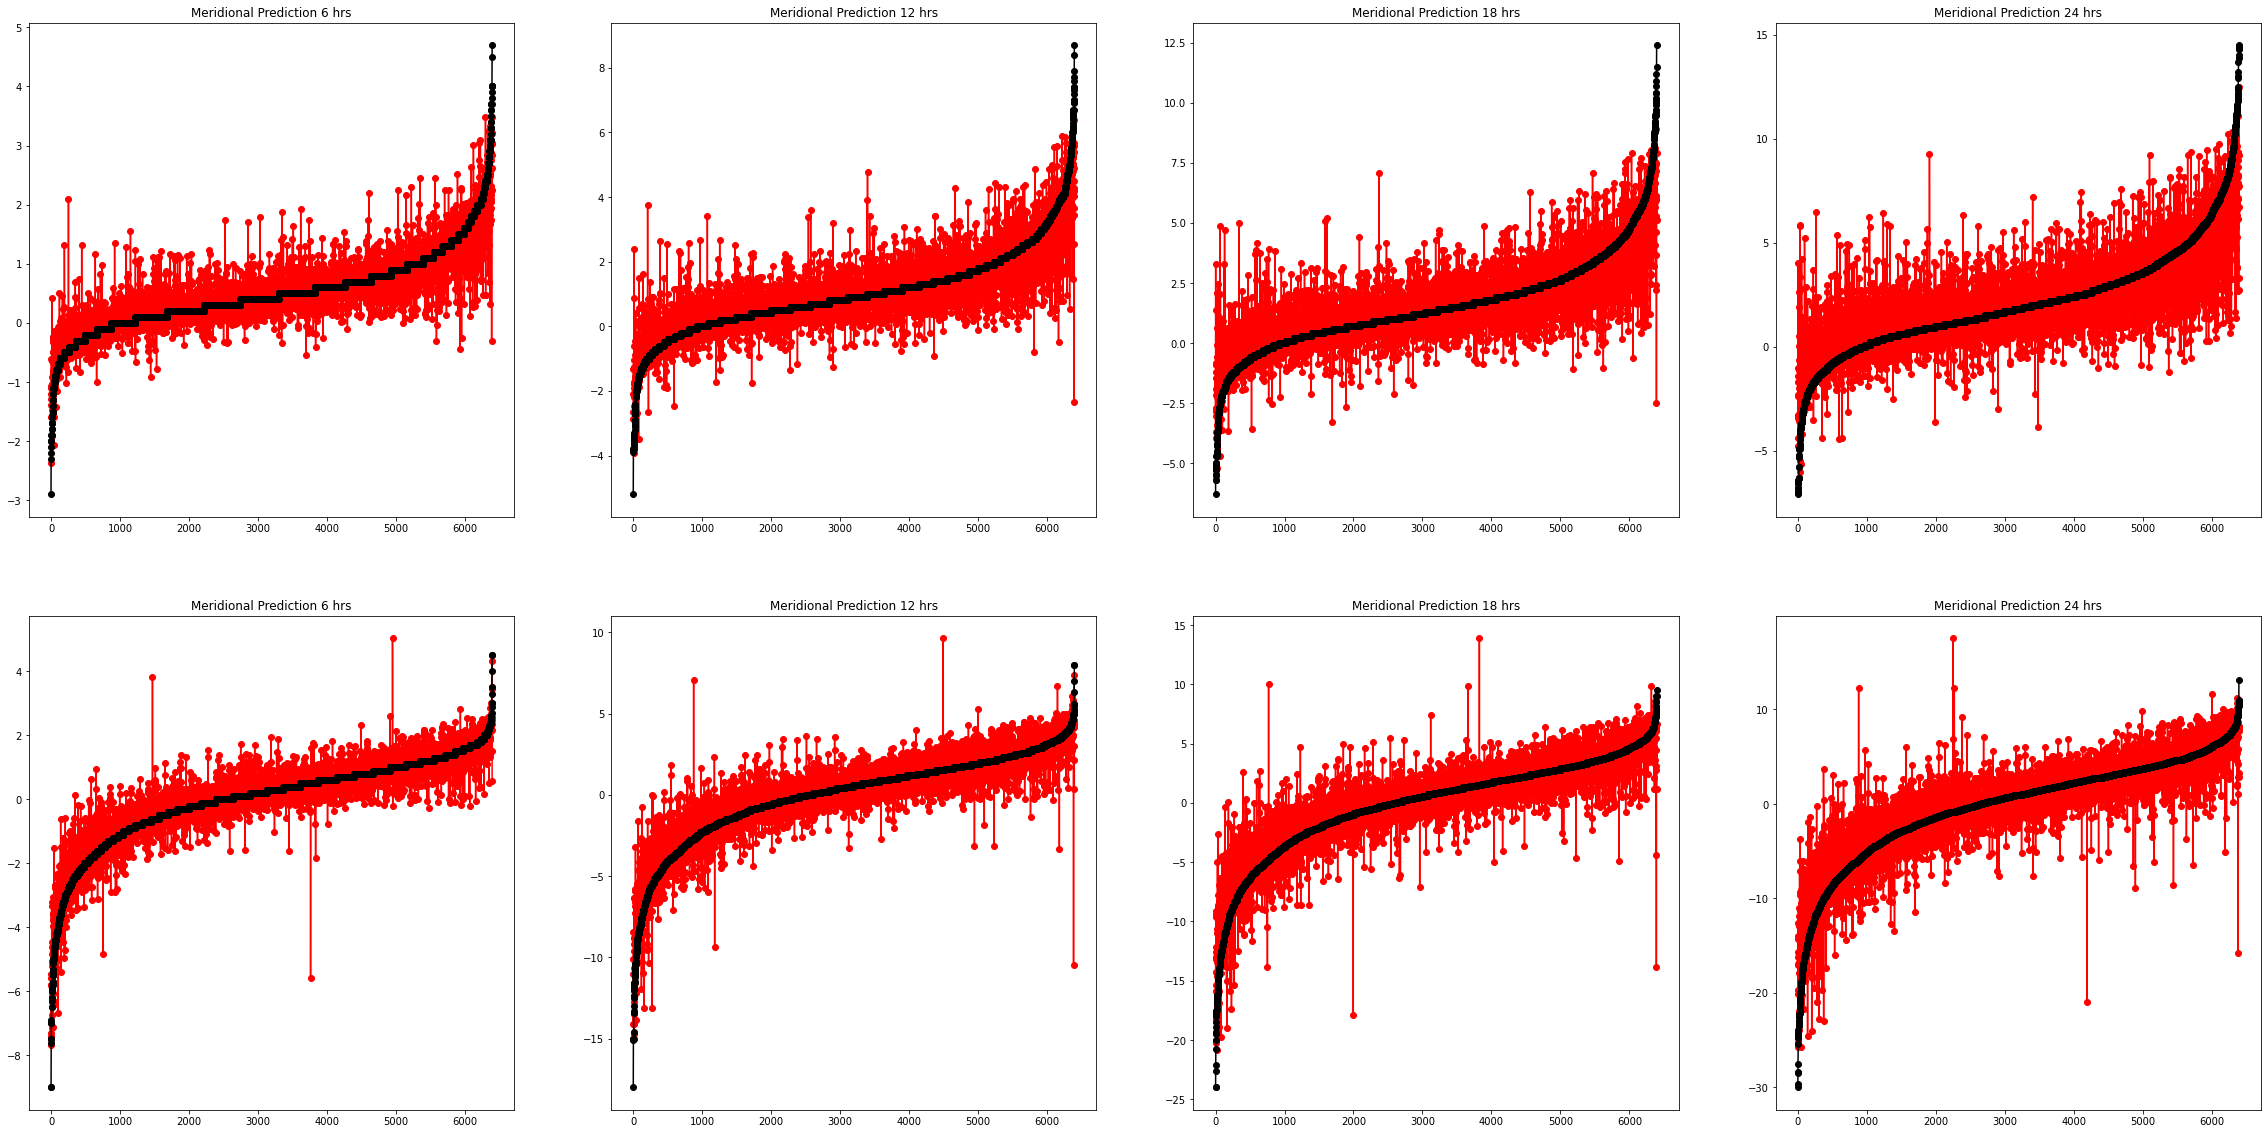

In [22]:
ind = np.empty((test_target.shape[0],8))
for i in range(0,8):
    ind[:,i] = np.argsort(test_target[:,i])

plt.figure(figsize=(40,20))
plt.title('Polynomial Regression Predictions')
for i in range(1, 5):
    plt.subplot(2,4,i)
    plt.plot(test_Meridional[np.int_(ind[:,i-1]),:] @ cm[:,i-1], 'r-', marker='o')
    plt.plot(test_target[np.int_(ind[:,i-1]),i-1], 'k-', marker='o')
    plt.title('Meridional Prediction '+str(i*6)+' hrs')
for i in range(5, 9):
    plt.subplot(2,4,i)
    plt.plot(test_Zonal[np.int_(ind[:,i-1]),:] @ cz[:,i-5], 'r-', marker='o')
    plt.plot(test_target[np.int_(ind[:,i-1]),i-1], 'k-', marker='o')
    plt.title('Meridional Prediction '+str((i-4)*6)+' hrs')
plt.show()

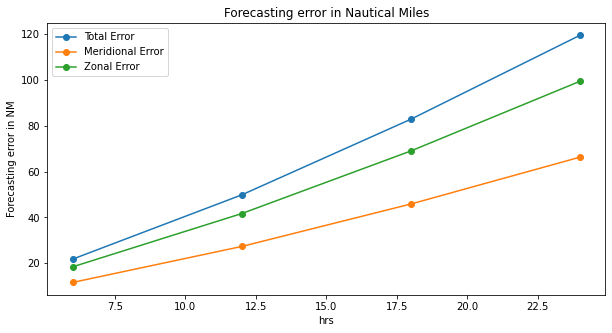

In [23]:
err_Meridional = np.sum(np.abs(test_target[:,:4]-test_Meridional.dot(cm)),0)/test_target.shape[0]
err_Zonal = np.sum(np.abs(test_target[:,4:]-test_Zonal.dot(cz)),0)/test_target.shape[0]
err = np.sqrt(err_Meridional**2+err_Zonal**2)
t = [6, 12, 18, 24]
plt.figure(figsize=(10,5))
plt.plot(t,err*60, marker='o')
plt.plot(t,err_Meridional*60, marker='o')
plt.plot(t,err_Zonal*60, marker='o')
plt.legend(['Total Error', 'Meridional Error', 'Zonal Error'])
plt.title('Forecasting error in Nautical Miles')
plt.xlabel('hrs')
plt.ylabel('Forecasting error in NM')
plt.show()

Visualisation of Forecast with polynomial regression

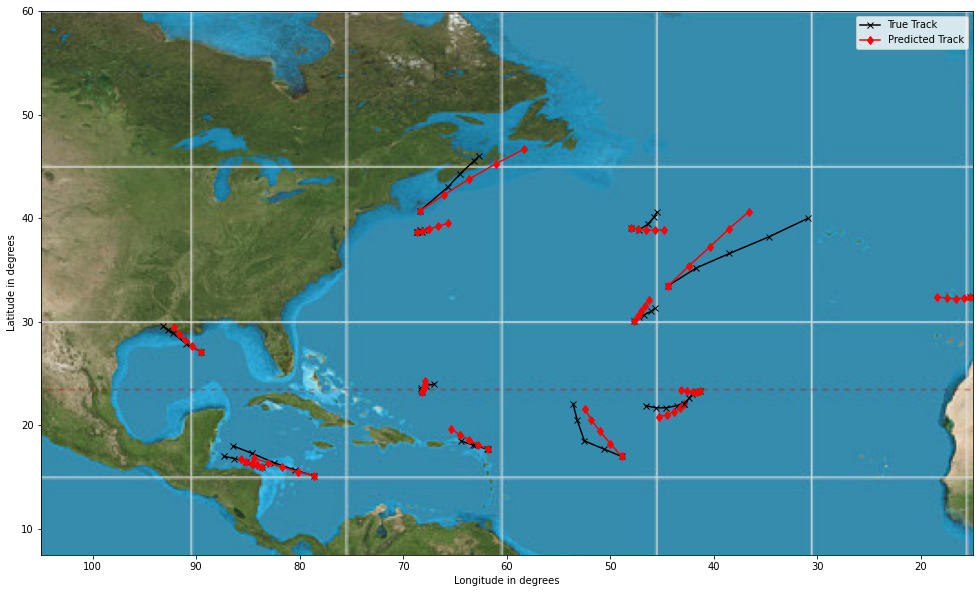

In [24]:
visualise()